# **HW2**
**NAME:** JANGA TUSHITA SHARVA  
**ROLL NUMBER:** CS21BTECH11022

In [1]:
# Libraries import
import numpy as np
import scipy
import matplotlib.pyplot as plt
from PIL import Image
import warnings
warnings.filterwarnings("ignore")

### **QUESTION 1: DISTANCE BETWEEN PDFs**

### 1A: Cross Entropy

Helper functions

In [2]:
ERROR_UNEQUAL_SPACES = -1
ERROR_INVALID_PMF = -2
ERROR_INF_DIVERGENCE = -3

def get_entropy(distr):
    if not np.isclose(np.sum(distr), 1):
        print(ERROR_INVALID_PMF)
        return ERROR_INVALID_PMF

    entropy = 0.0
    for i in distr:
        if i > 0.0:
            entropy -= i * np.log2(i)
    return entropy

def get_normalized_historgram_of_image(filepath):
    img = np.asarray(Image.open(filepath))
    freq = np.zeros(256)
    num_pixels = img.size
    for i in img:
        for j in i:
            freq[j] += 1
    freq = freq/num_pixels
    
    return freq

def get_kl_divergence(distr1, distr2):
    divergence = 0.0
    n1 = distr1.shape
    n2 = distr2.shape

    if(n1 != n2):
        return ERROR_UNEQUAL_SPACES
    
    for i in range(n1[0]):
        if distr1[i] > 0.0 and distr2[i] > 0.0:
            divergence += distr1[i] * np.log2(distr1[i]/distr2[i])
        elif distr2[i] == 0.0 and distr1[i] != 0.0:
            return ERROR_INF_DIVERGENCE

    return divergence

### (i)

In [3]:
# Function for finding cross entropy
def get_cross_entropy(p, q):
    ENT = get_entropy(p)
    DIV = get_kl_divergence(p, q)
    return ENT+DIV

p = get_normalized_historgram_of_image('left.png')
q = get_normalized_historgram_of_image('right.png')

print(get_cross_entropy(p,q))
print(get_cross_entropy(q,p))

7.273398119987328
7.293035317529478


### (ii)

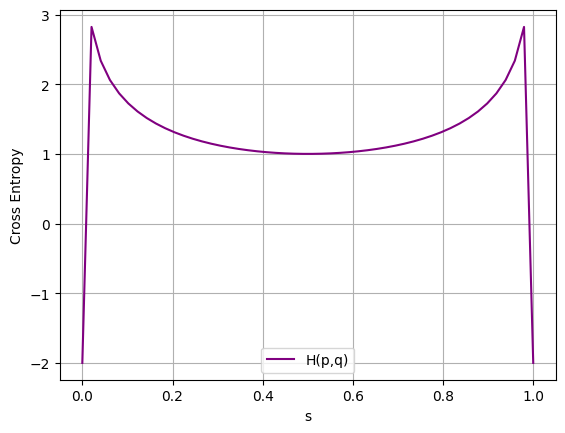

In [4]:
def plot_cross_entropy(r):
    s_space = np.linspace(0, 1)
    cross_entropy_pq = []

    for s in s_space:
        p = np.array([r, 1-r])
        q = np.array([s, 1-s])
        cross_entropy_pq.append(get_cross_entropy(p, q))
        
    plt.plot(s_space, cross_entropy_pq, color='purple', label='H(p,q)')
    plt.grid(True)
    plt.xlabel('s')
    plt.ylabel('Cross Entropy')
    plt.legend()
    plt.show()

plot_cross_entropy(0.5)

Yes, as we can see from the above, a minimum is obtained when both the PMFs match.

### 1B: JS Divergence

In [5]:
def get_js_divergence(p, q):
    m = (p + q)/2
    return 0.5 * (get_kl_divergence(p , m) + get_kl_divergence(q, m))

p = get_normalized_historgram_of_image('left.png')
q = get_normalized_historgram_of_image('right.png')

print(get_js_divergence(p,q), get_js_divergence(q,p))
print(get_kl_divergence(p,q), get_kl_divergence(q,p))

0.0036730397693148257 0.0036730397693148257
0.015104015237387055 0.014409785833354494


Hence verified that KL divergence is not symmetric whereas JS divergence is

### 1C: Wasserstein Distance

In [8]:
# This uses loops, might have performance issues
def check_joint_histogram(pXY, rX, sY):
    rows = len(pXY)
    cols = len(pXY[0])

    computed_rX = [0] * rows
    computed_sY = [0] * cols
    
    # Marginal rX
    for row in range(rows):
        for col in range(cols):
            computed_rX[row] += pXY[row][col]
            computed_sY[col] += pXY[row][col]
            
    for i in range(rows):
        if not np.isclose(computed_rX[i], rX[i]):
            return False
    
    for j in range(cols):
        if not np.isclose(computed_sY[j], sY[j]):
            return False
    
    return True

# Optimised version, using np sum
def check_joint_histogram_opt(pXY, rX, sY):

    computed_sY = np.sum(pXY, axis=0)
    computed_rX = np.sum(pXY, axis=1)
    
    if np.allclose(computed_rX, rX) and np.allclose(computed_sY, sY):
        return True
    else:
        return False


# Positive Sample
pXY = [[0.2, 0.1], [0.3, 0.4]]
rX = [0.3, 0.7]
sY = [0.5, 0.5]
# print(check_joint_histogram(pXY, rX, sY))
print(check_joint_histogram_opt(pXY, rX, sY))

# Negative Sample
pXY = [[0.2, 0.1], [0.3, 0.4]]
rX = [0.4, 0.6]
sY = [0.5, 0.5]
# print(check_joint_histogram(pXY, rX, sY))
print(check_joint_histogram_opt(pXY, rX, sY))

True
False


### **QUESTION 2: VISUALIZING DATA USING t-SNE**

### 2A